In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from collections import Counter
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, accuracy_score
#from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2025-08-13 05:42:46.566760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755063766.948935      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755063767.055230      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch
from torchvision import datasets

# Data Preparation

In [4]:
dataset_path = '/kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2'  

In [5]:
dataset = datasets.ImageFolder(root= dataset_path)
dataset

Dataset ImageFolder
    Number of datapoints: 11989
    Root location: /kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2

In [6]:
class_names = dataset.classes

In [16]:
import tensorflow as tf

data_dir = dataset_path
img_size = (224, 224)
batch_size = 32

# 80% train+val
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 11986 files belonging to 20 classes.
Using 9589 files for training.
Found 11986 files belonging to 20 classes.
Using 2397 files for validation.


In [17]:
# Calculate dataset sizes
train_val_size = train_val_ds.cardinality().numpy()
train_size = int(train_val_size * 0.75)
val_size = train_val_size - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [10]:
batch_size = 32  # Use the same batch size you set

def dataset_size(dataset):
    # Get number of batches
    batches = dataset.cardinality().numpy()
    if batches == tf.data.INFINITE_CARDINALITY or batches == tf.data.UNKNOWN_CARDINALITY:
        return "Unknown size"
    else:
        return batches * batch_size

print("Train set size:", dataset_size(train_ds))
print("Validation set size:", dataset_size(val_ds))
print("Test set size:", dataset_size(test_ds))


Train set size: 7200
Validation set size: 2400
Test set size: 2400


# Training

## VGG16

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

num_classes = len(class_names)

# Load VGG16 without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional base

# Build model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,612 (80.65 MB)

 Trainable params: 6,427,924 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20


I0000 00:00:1755035208.673606     107 service.cc:148] XLA service 0x78079400d890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755035208.679808     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755035208.679834     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755035209.661465     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:09:34 19s/step - accuracy: 0.0625 - loss: 22.9332

I0000 00:00:1755035224.711808     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 138s 535ms/step - accuracy: 0.2686 - loss: 7.2150 - val_accuracy: 0.5274 - val_loss: 1.7009
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 452ms/step - accuracy: 0.5688 - loss: 1.4342 - val_accuracy: 0.6329 - val_loss: 1.3750
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 454ms/step - accuracy: 0.7143 - loss: 0.9210 - val_accuracy: 0.6702 - val_loss: 1.2635
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 103s 459ms/step - accuracy: 0.7756 - loss: 0.7101 - val_accuracy: 0.6915 - val_loss: 1.1744
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 455ms/step - accuracy: 0.8227 - loss: 0.5362 - val_accuracy: 0.6953 - val_loss: 1.2247
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 101s 451ms/step - accuracy: 0.8568 - loss: 0.4333 - val_accuracy: 0.7158 - val_loss: 1.1643
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 454ms/step - accuracy: 0.8932 - loss: 0.3300 - val_accuracy: 0.7296 - val_loss: 1.2104
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 101s 451ms/step - accuracy: 0.9009 - loss: 0.29

In [19]:
hist_training=pd.DataFrame(history.history)
hist_training

,accuracy,loss,val_accuracy,val_loss
0,0.335000,4.022186,0.527417,1.700916
1,0.569444,1.446210,0.632901,1.375001
2,0.694583,0.984112,0.670155,1.263457
3,0.762361,0.751442,0.691503,1.174354
4,0.809028,0.594997,0.695270,1.224696
5,0.848194,0.463646,0.715781,1.164264
6,0.879861,0.370721,0.729594,1.210421
7,0.893333,0.314355,0.733361,1.226424
8,0.908611,0.283702,0.740896,1.268664
9,0.911667,0.279139,0.732943,1.293230


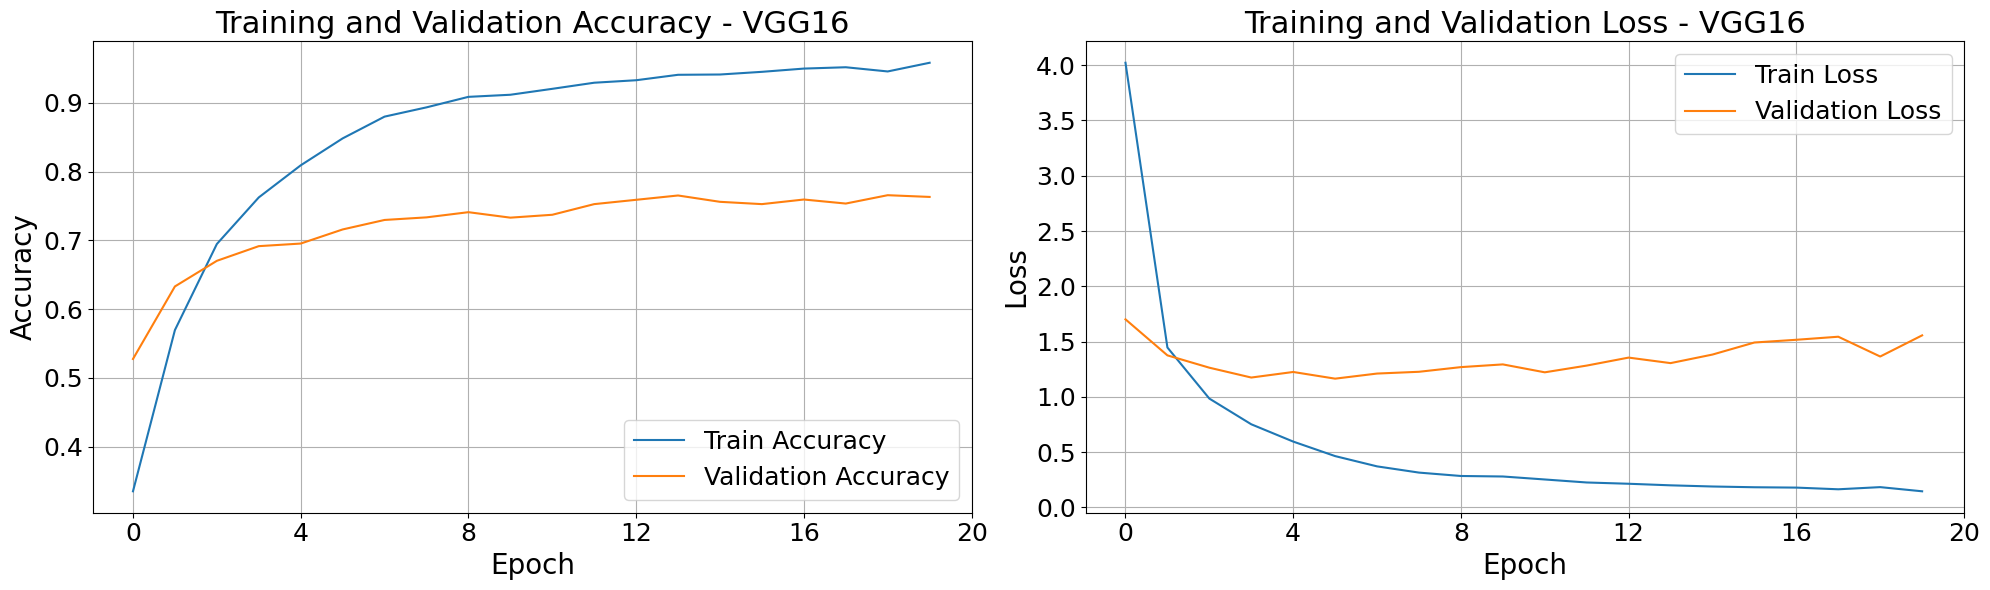

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - VGG16', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - VGG16', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('vgg_training_curves.png', dpi=600)
plt.savefig('vgg_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

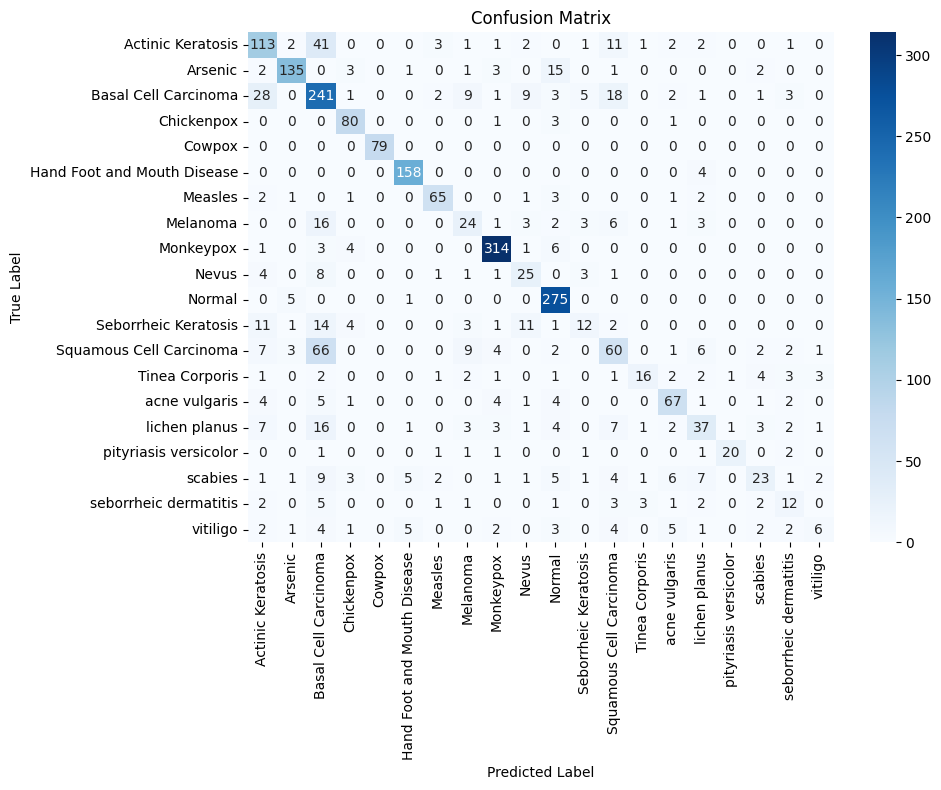

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('vgg_confusion_matrix.png', dpi=600)
plt.savefig('vgg_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('performance_metrics.csv', index=False)

## MobileNetV2

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the top classifier layers
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers if you want to train only classifier first
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)   # extra dense layer
x = layers.Dropout(0.3)(x)
output = layers.Dense(20, activation='softmax')(x)  # 20 classes

model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2532 - loss: 2.6011
Epoch 1: val_loss improved from inf to 2.03475, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 138s 560ms/step - accuracy: 0.2534 - loss: 2.6000 - val_accuracy: 0.3654 - val_loss: 2.0348
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3677 - loss: 2.0654
Epoch 2: val_loss improved from 2.03475 to 1.90043, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 416ms/step - accuracy: 0.3678 - loss: 2.0652 - val_accuracy: 0.4152 - val_loss: 1.9004
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3947 - loss: 1.8861
Epoch 3: val_loss improved from 1.90043 to 1.78676, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 413ms/step - accuracy: 0.3948 - loss: 1.8861 - val_accuracy: 0.4496 - val_loss: 1.7868
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.4372 - loss: 1.7707
Epoch 4: val_loss improved from 1.78676 to 1.

In [42]:
hist_training=pd.DataFrame(history.history)
hist_training

,accuracy,loss,val_accuracy,val_loss
0,0.298611,2.347626,0.365425,2.034755
1,0.372639,2.016392,0.415237,1.900432
2,0.404028,1.870808,0.449560,1.786756
3,0.441528,1.758251,0.456676,1.723917
4,0.464167,1.689793,0.468397,1.662088
5,0.484583,1.615009,0.494768,1.614262
6,0.495694,1.559903,0.498954,1.590486
7,0.524028,1.490452,0.514441,1.522926
8,0.526667,1.463775,0.504395,1.537889
9,0.542778,1.425559,0.524069,1.491209


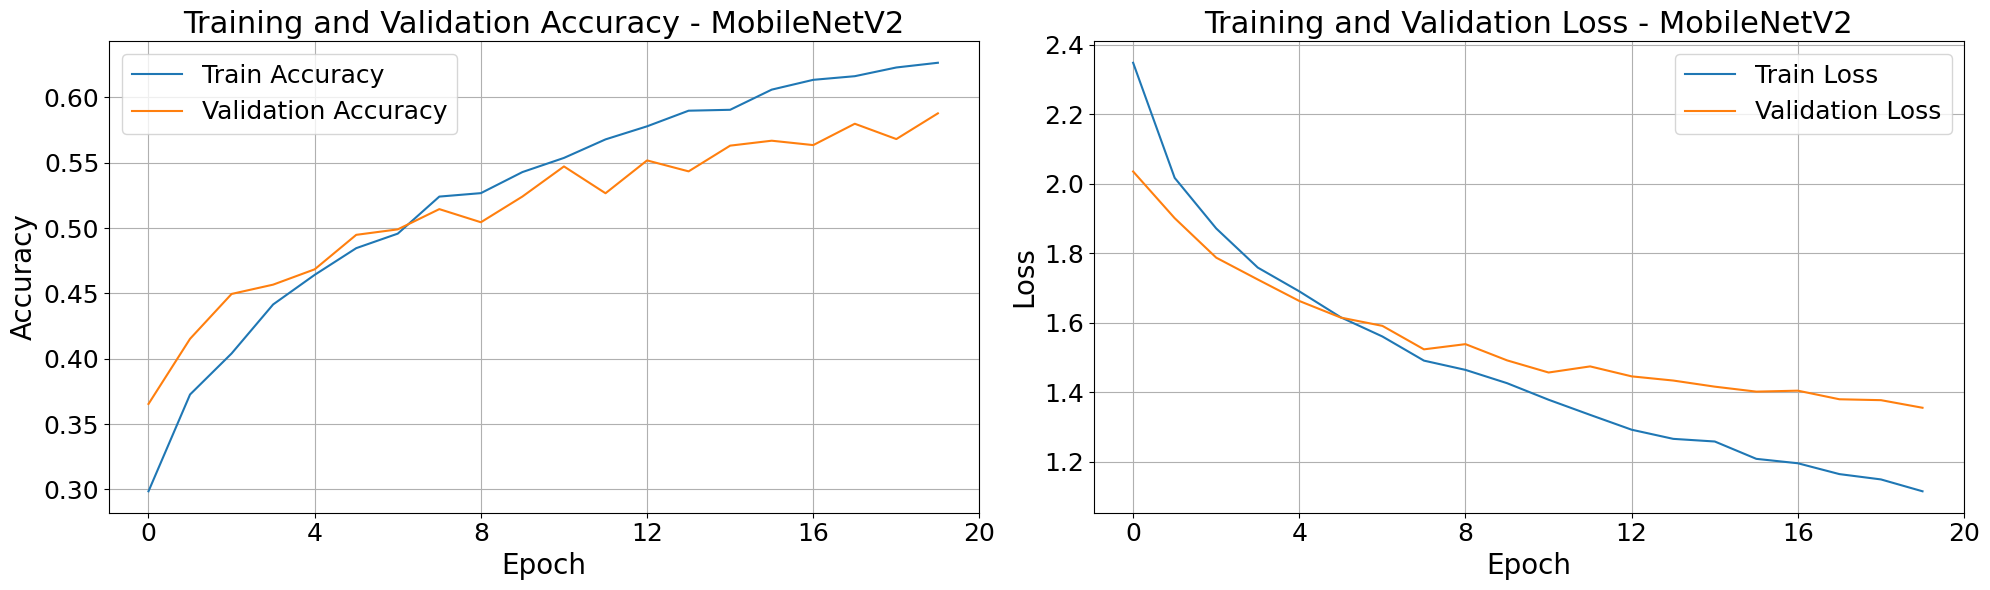

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - MobileNetV2', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - MobileNetV2', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('mobilenet_training_curves.png', dpi=600)
plt.savefig('mobilenet_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/

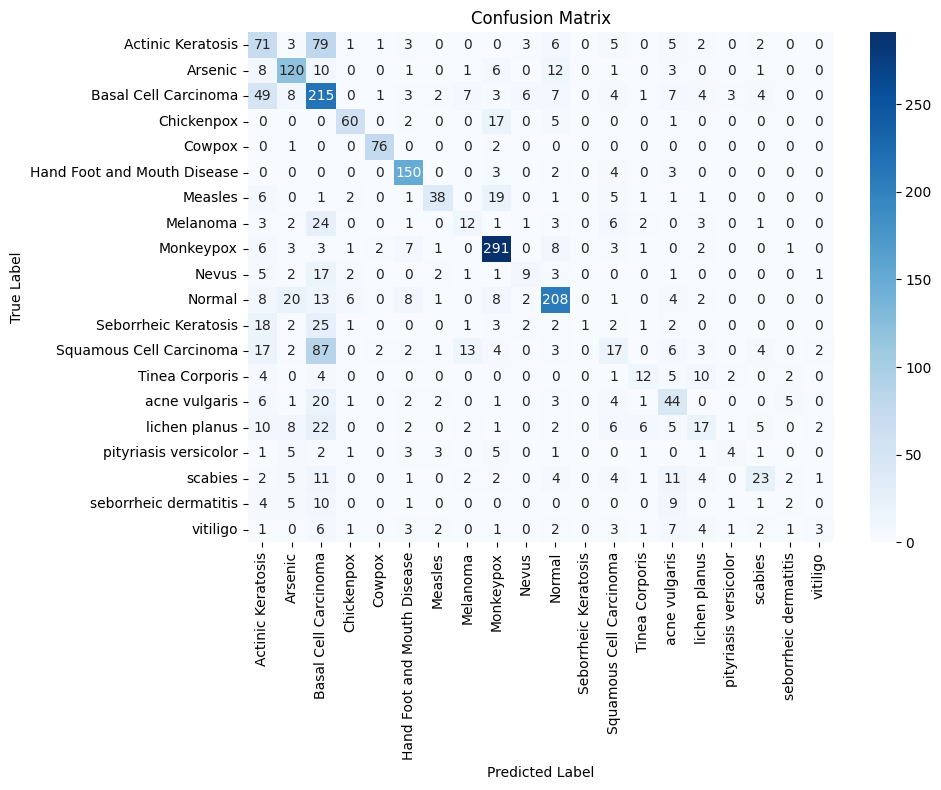

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('mobilenet_confusion_matrix.png', dpi=600)
plt.savefig('mobilenet_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('mobilenet_performance_metrics.csv', index=False)

## MobileNetV2 - version 2

In [19]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

# Preprocess entire batches
def preprocess_batch(images, labels):
    images = preprocess_input(images)
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [20]:
# 3. Build the model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base initially

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(20, activation='softmax')(x)  # adjust 20 to your number of classes

model = models.Model(inputs=base_model.input, outputs=output)

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

#model.summary()

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


I0000 00:00:1755064404.621270     107 service.cc:148] XLA service 0x7b4eb00039e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755064404.626336     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755064404.626360     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755064406.176593     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/225 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0941 - loss: 3.1932 

I0000 00:00:1755064412.560917     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4186 - loss: 1.9837
Epoch 1: val_loss improved from inf to 1.11409, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 140s 557ms/step - accuracy: 0.4191 - loss: 1.9821 - val_accuracy: 0.6459 - val_loss: 1.1141
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6555 - loss: 1.0692
Epoch 2: val_loss improved from 1.11409 to 0.92584, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 101s 449ms/step - accuracy: 0.6555 - loss: 1.0690 - val_accuracy: 0.7145 - val_loss: 0.9258
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7629 - loss: 0.7180
Epoch 4: val_loss improved from 0.86648 to 0.78960, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 99s 441ms/step - accuracy: 0.7629 - loss: 0.7180 - val_accuracy: 0.7509 - val_loss: 0.7896
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8034 - loss: 0.6120
Epoch 5: val_loss improved from 0.78960 to 0.78316, sav

In [26]:
hist_training=pd.DataFrame(history.history)
hist_training

,accuracy,loss,val_accuracy,val_loss
0,0.514861,1.617497,0.645877,1.114093
1,0.662778,1.040456,0.714525,0.925836
2,0.726250,0.835068,0.723315,0.866484
3,0.765000,0.707897,0.750942,0.789605
4,0.797778,0.614576,0.755965,0.783160
5,0.822639,0.541546,0.766011,0.764920
6,0.838750,0.477539,0.771034,0.772681
7,0.855694,0.425990,0.766848,0.772435
8,0.874861,0.374936,0.768104,0.769482
9,0.889861,0.335465,0.784010,0.739210


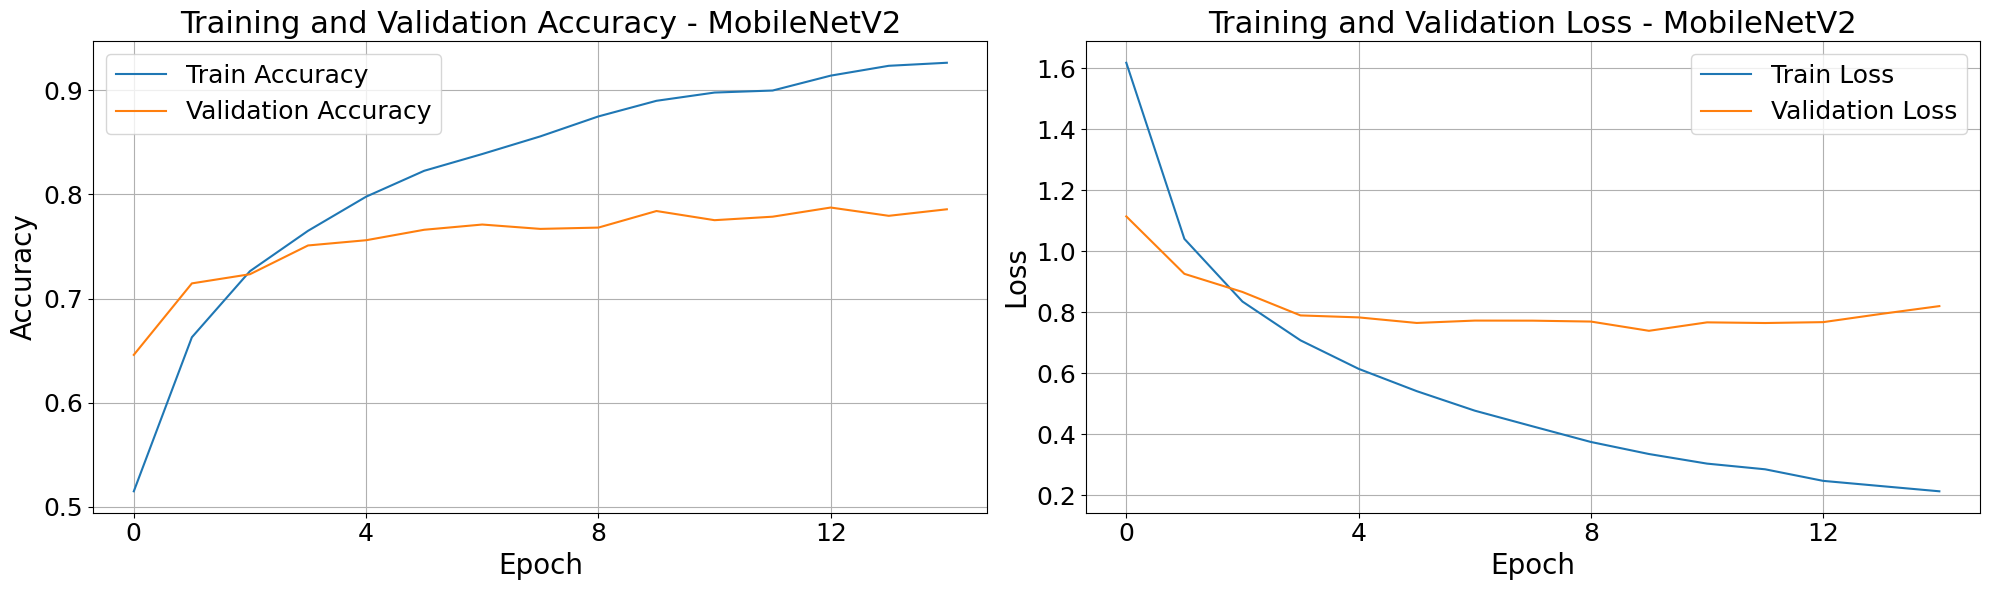

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - MobileNetV2', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - MobileNetV2', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('mobilenet_training_curves.png', dpi=600)
plt.savefig('mobilenet_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/

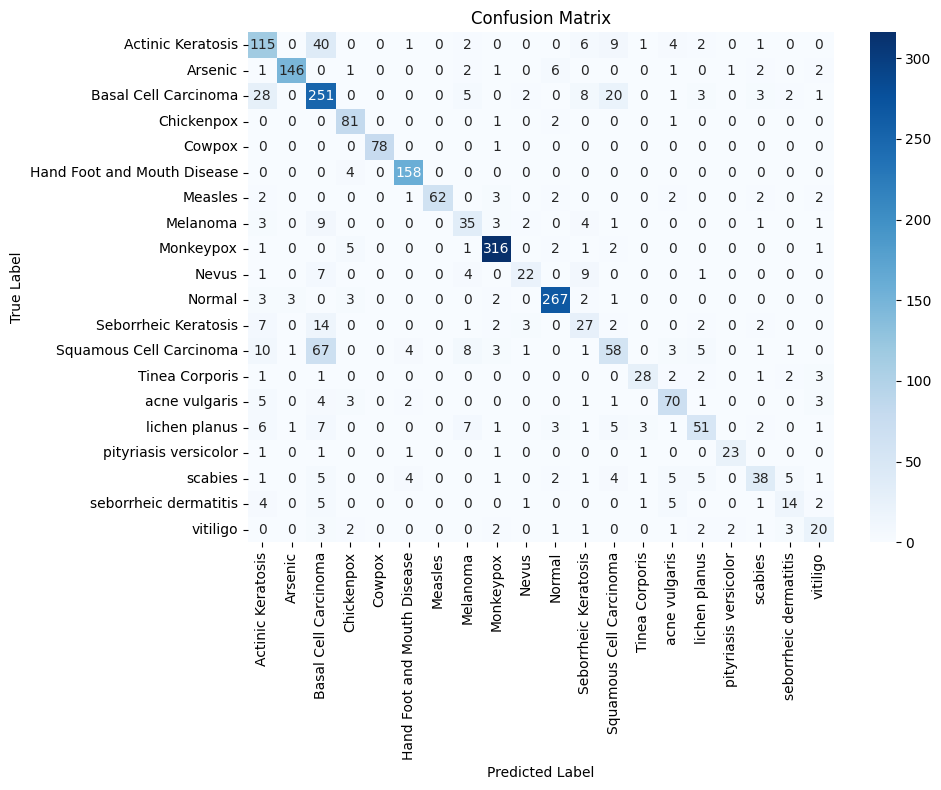

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('mobilenet_confusion_matrix.png', dpi=600)
plt.savefig('mobilenet_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('mobilenet_performance_metrics.csv', index=False)

## InceptionV3

In [29]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models

# =========================
# Dataset creation
# =========================
data_dir = dataset_path  # your dataset folder
img_size = (299, 299)    # InceptionV3 expects 299x299
batch_size = 32

# 80% train+val
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Split train_val into train and val
train_val_size = train_val_ds.cardinality().numpy()
train_size = int(train_val_size * 0.75)
val_size = train_val_size - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

# =========================
# Preprocessing function
# =========================
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_batch(images, labels):
    images = preprocess_input(images)  # Apply InceptionV3 preprocessing
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 11986 files belonging to 20 classes.
Using 9589 files for training.
Found 11986 files belonging to 20 classes.
Using 2397 files for validation.


In [30]:
# =========================
# Model setup (Transfer Learning)
# =========================
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_val_ds.class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,332,468 (85.19 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2169 - loss: 2.6326
Epoch 1: val_loss did not improve from 0.73921
225/225 ━━━━━━━━━━━━━━━━━━━━ 136s 502ms/step - accuracy: 0.2173 - loss: 2.6313 - val_accuracy: 0.4897 - val_loss: 1.8021
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.4572 - loss: 1.8239
Epoch 2: val_loss did not improve from 0.73921
225/225 ━━━━━━━━━━━━━━━━━━━━ 101s 449ms/step - accuracy: 0.4573 - loss: 1.8236 - val_accuracy: 0.5437 - val_loss: 1.5105
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5327 - loss: 1.5370
Epoch 3: val_loss did not improve from 0.73921
225/225 ━━━━━━━━━━━━━━━━━━━━ 99s 440ms/step - accuracy: 0.5327 - loss: 1.5370 - val_accuracy: 0.5877 - val_loss: 1.3667
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5706 - loss: 1.3838
Epoch 4: val_loss did not improve from 0.73921
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 454ms/step - accuracy: 0.5706 - loss: 1.3837 - val_accuracy: 0.6

In [33]:
hist_training=pd.DataFrame(history.history)
hist_training

,accuracy,loss,val_accuracy,val_loss
0,0.309306,2.344963,0.489745,1.802073
1,0.472222,1.757864,0.543742,1.510494
2,0.532083,1.521530,0.587694,1.366674
3,0.571250,1.374926,0.613646,1.273934
4,0.620000,1.240662,0.639180,1.195670
5,0.633889,1.164030,0.655923,1.132508
6,0.657083,1.089126,0.666806,1.101539
7,0.668056,1.043428,0.685224,1.064463
8,0.691111,0.983079,0.681038,1.033149
9,0.700833,0.937956,0.696944,0.986760


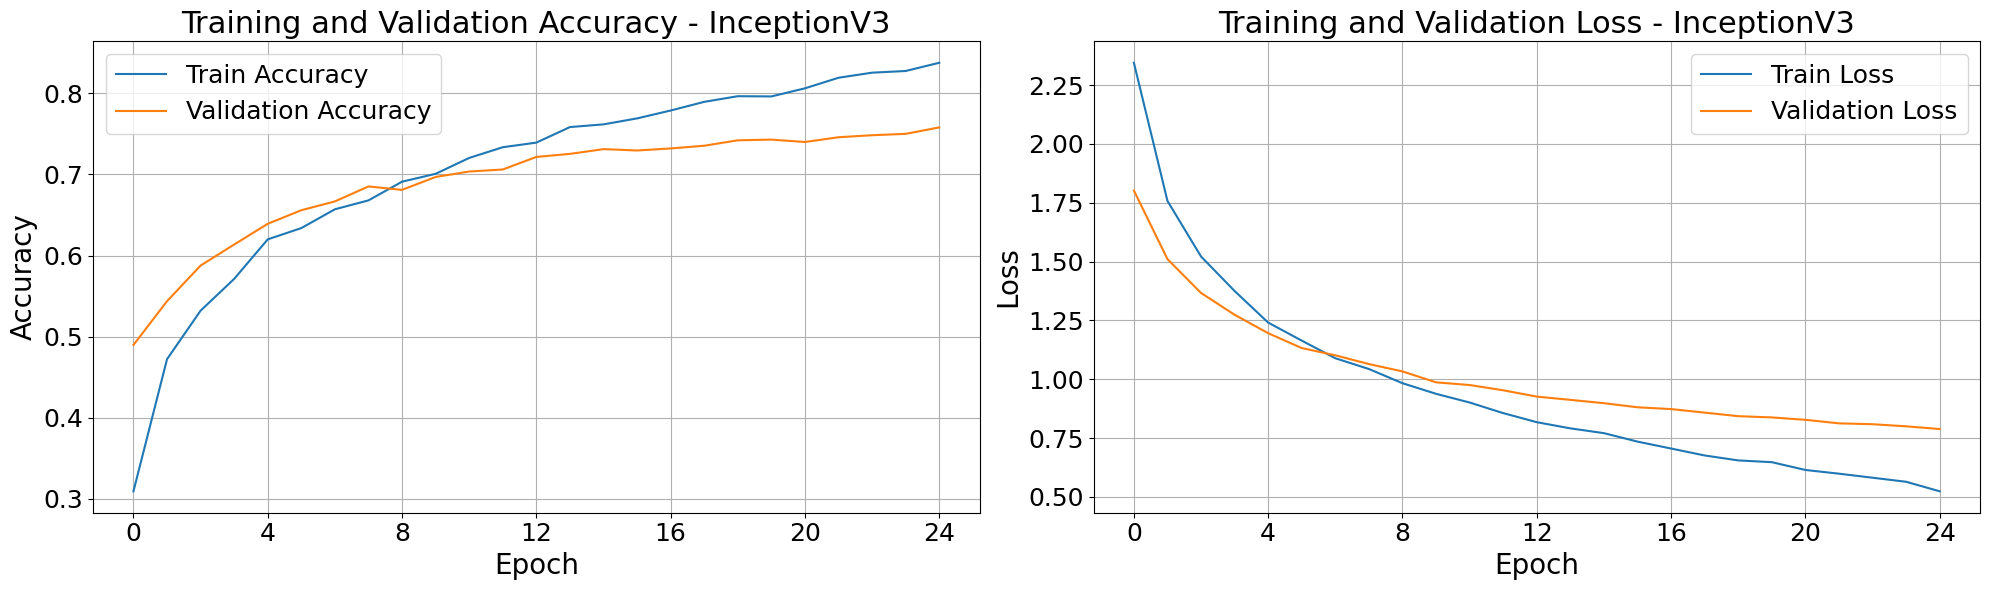

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - InceptionV3', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - InceptionV3', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('InceptionV3_training_curves.png', dpi=600)
plt.savefig('InceptionV3_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

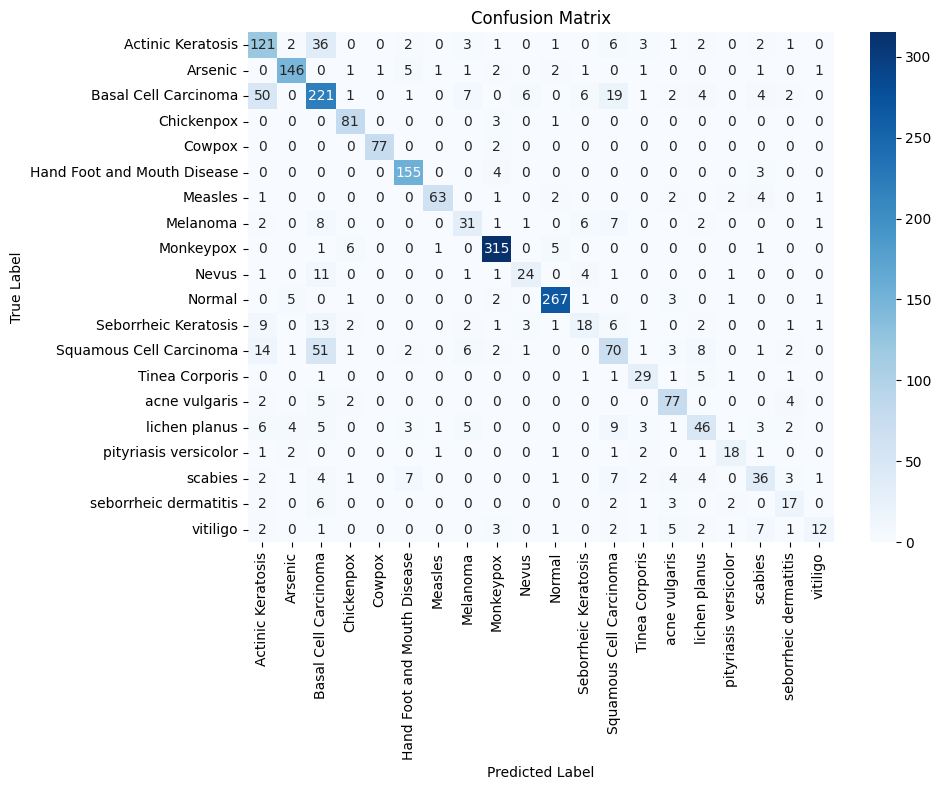

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('InceptionV3_confusion_matrix.png', dpi=600)
plt.savefig('InceptionV3_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('InceptionV3_performance_metrics.csv', index=False)

## EfficientNetB0

In [40]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras import layers, models

# =========================
# Dataset creation
# =========================
data_dir = dataset_path  # your dataset folder
img_size = (224, 224)    # EfficientNetB0 expects 224x224
batch_size = 32

# 80% train+val
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Split train_val into train and val
train_val_size = train_val_ds.cardinality().numpy()
train_size = int(train_val_size * 0.75)
val_size = train_val_size - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

# =========================
# Preprocessing function
# =========================
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_batch(images, labels):
    images = preprocess_input(images)  # EfficientNetB0 preprocessing
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# =========================
# Model creation
# =========================
num_classes = len(train_val_ds.class_names)

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Found 11986 files belonging to 20 classes.
Using 9589 files for training.
Found 11986 files belonging to 20 classes.
Using 2397 files for validation.


In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,216,119 (16.08 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

In [43]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.1656 - loss: 2.8428
Epoch 1: val_loss improved from inf to 2.07971, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 130s 466ms/step - accuracy: 0.1660 - loss: 2.8416 - val_accuracy: 0.4487 - val_loss: 2.0797
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4001 - loss: 2.0975
Epoch 2: val_loss improved from 2.07971 to 1.69607, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 423ms/step - accuracy: 0.4002 - loss: 2.0971 - val_accuracy: 0.5119 - val_loss: 1.6961
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4791 - loss: 1.7991
Epoch 3: val_loss improved from 1.69607 to 1.49219, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 426ms/step - accuracy: 0.4792 - loss: 1.7989 - val_accuracy: 0.5710 - val_loss: 1.4922
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5247 - loss: 1.5973
Epoch 4: val_loss improved from 1.49219 to 1.

In [44]:
hist_training=pd.DataFrame(history.history)
hist_training

,accuracy,loss,val_accuracy,val_loss
0,0.255417,2.583589,0.448723,2.079712
1,0.424028,2.006896,0.511930,1.696074
2,0.489028,1.745896,0.570950,1.492187
3,0.529167,1.572327,0.601925,1.357815
4,0.566667,1.457182,0.628296,1.272385
5,0.581250,1.362806,0.645040,1.194838
6,0.606250,1.292134,0.653411,1.152784
7,0.621944,1.223831,0.664295,1.104363
8,0.638889,1.173613,0.673504,1.068197
9,0.643333,1.137112,0.688991,1.024123


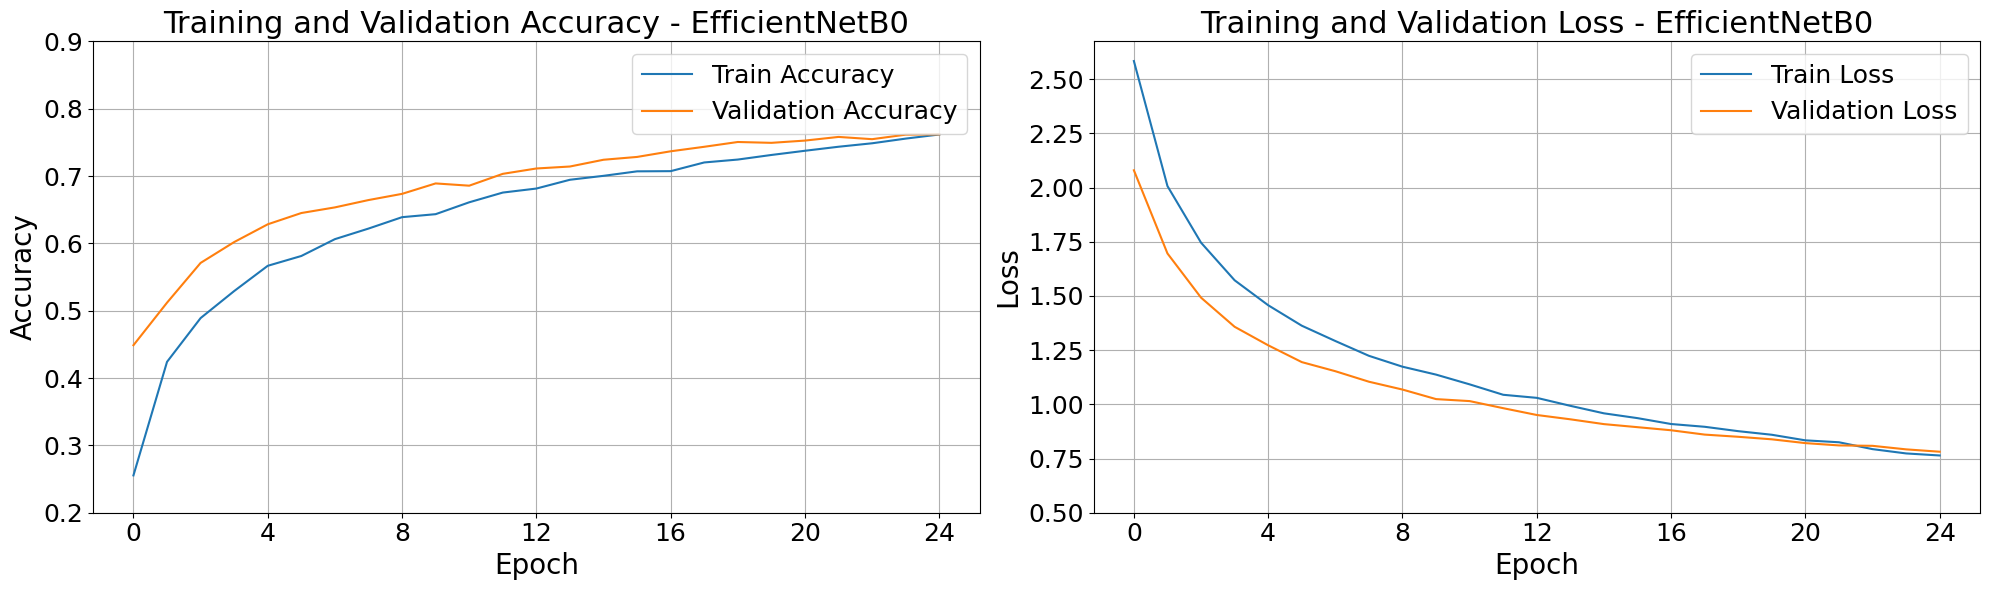

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, num_epochs + 1, 4)

# Plot accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - EfficientNetB0', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].set_yticks(np.arange(0.2, 1.0, 0.1))
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - EfficientNetB0', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].set_yticks(np.arange(0.5,2.75,0.25))
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
#plt.savefig('EfficientNetB0_training_curves.png', dpi=600)
#plt.savefig('EfficientNetB0_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms

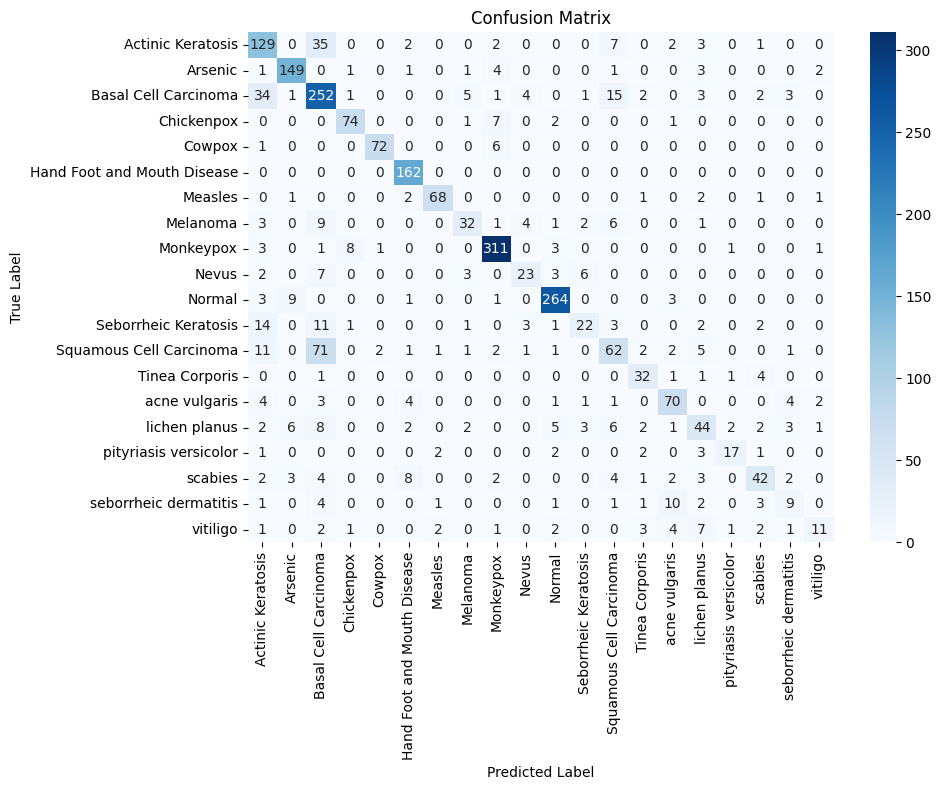

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('EfficientNetB0_confusion_matrix.png', dpi=600)
plt.savefig('EfficientNetB0_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('EfficientNetB0_performance_metrics.csv', index=False)

In [54]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=25,  # Start counting from 25
    epochs=30          # Total final epoch number
)

Epoch 26/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 427ms/step - accuracy: 0.7652 - loss: 0.7550 - val_accuracy: 0.7635 - val_loss: 0.7795
Epoch 27/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 416ms/step - accuracy: 0.7799 - loss: 0.7155 - val_accuracy: 0.7652 - val_loss: 0.7691
Epoch 28/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 420ms/step - accuracy: 0.7839 - loss: 0.7076 - val_accuracy: 0.7681 - val_loss: 0.7596
Epoch 29/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 416ms/step - accuracy: 0.7879 - loss: 0.6914 - val_accuracy: 0.7689 - val_loss: 0.7543
Epoch 30/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 97s 433ms/step - accuracy: 0.7885 - loss: 0.6952 - val_accuracy: 0.7748 - val_loss: 0.7433


In [55]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=30,  # Start counting from 25
    epochs=35          # Total final epoch number
)

Epoch 31/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 96s 426ms/step - accuracy: 0.7906 - loss: 0.6745 - val_accuracy: 0.7731 - val_loss: 0.7427
Epoch 32/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 92s 409ms/step - accuracy: 0.7911 - loss: 0.6783 - val_accuracy: 0.7765 - val_loss: 0.7354
Epoch 33/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 425ms/step - accuracy: 0.7936 - loss: 0.6657 - val_accuracy: 0.7740 - val_loss: 0.7282
Epoch 34/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 95s 423ms/step - accuracy: 0.8013 - loss: 0.6543 - val_accuracy: 0.7781 - val_loss: 0.7184
Epoch 35/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 97s 431ms/step - accuracy: 0.8023 - loss: 0.6525 - val_accuracy: 0.7798 - val_loss: 0.7177


In [56]:
acc = history.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss'] + history3.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']

epochs = range(1, len(acc) + 1)  # 1 to 35

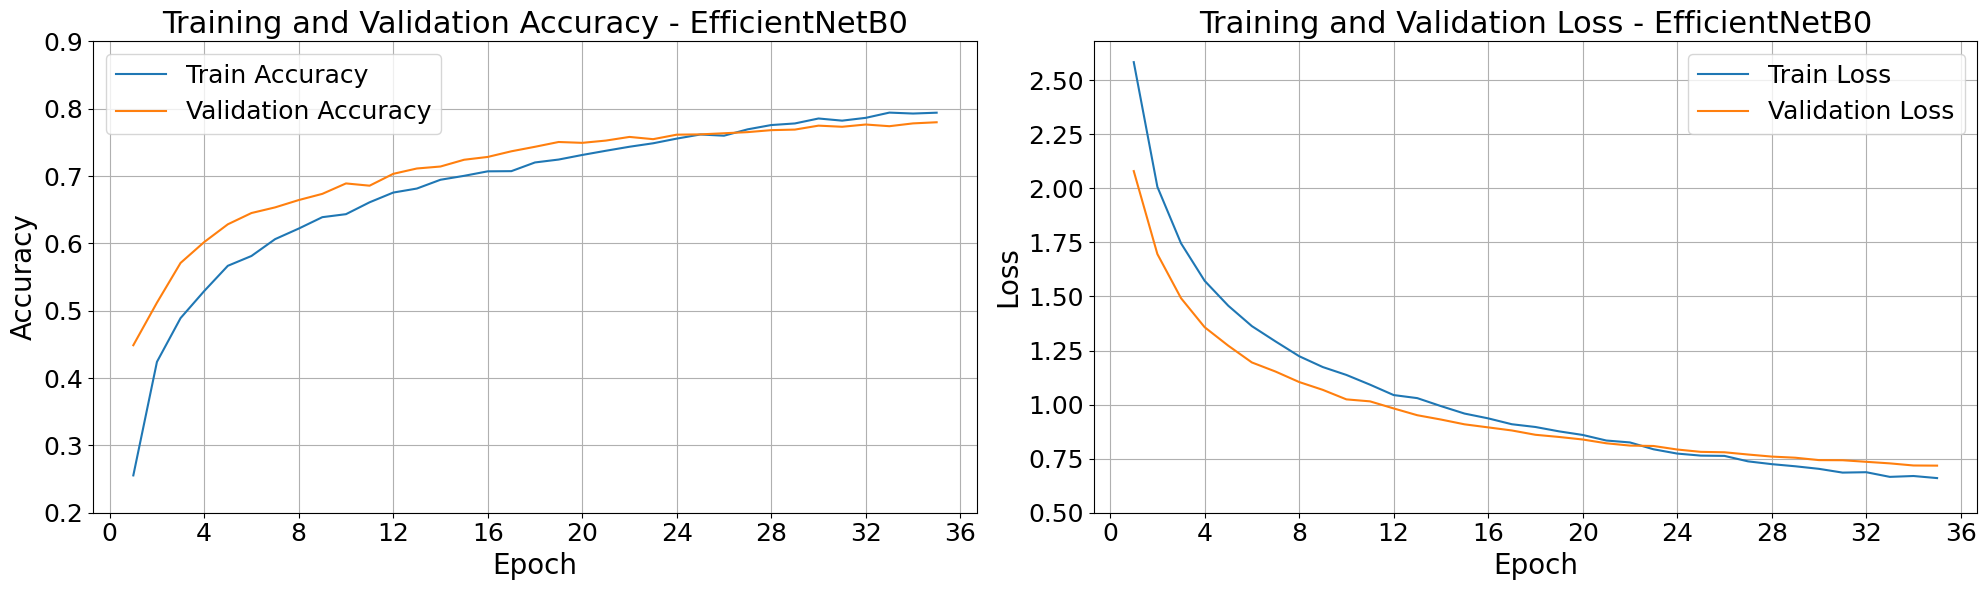

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, len(epochs) + 2, 4)

# Plot accuracy
axs[0].plot(epochs, acc, label='Train Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - EfficientNetB0', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].set_yticks(np.arange(0.2, 1.0, 0.1))
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(epochs, loss, label='Train Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - EfficientNetB0', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].set_yticks(np.arange(0.5,2.75,0.25))
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('EfficientNetB0_training_curves.png', dpi=600)
plt.savefig('EfficientNetB0_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st

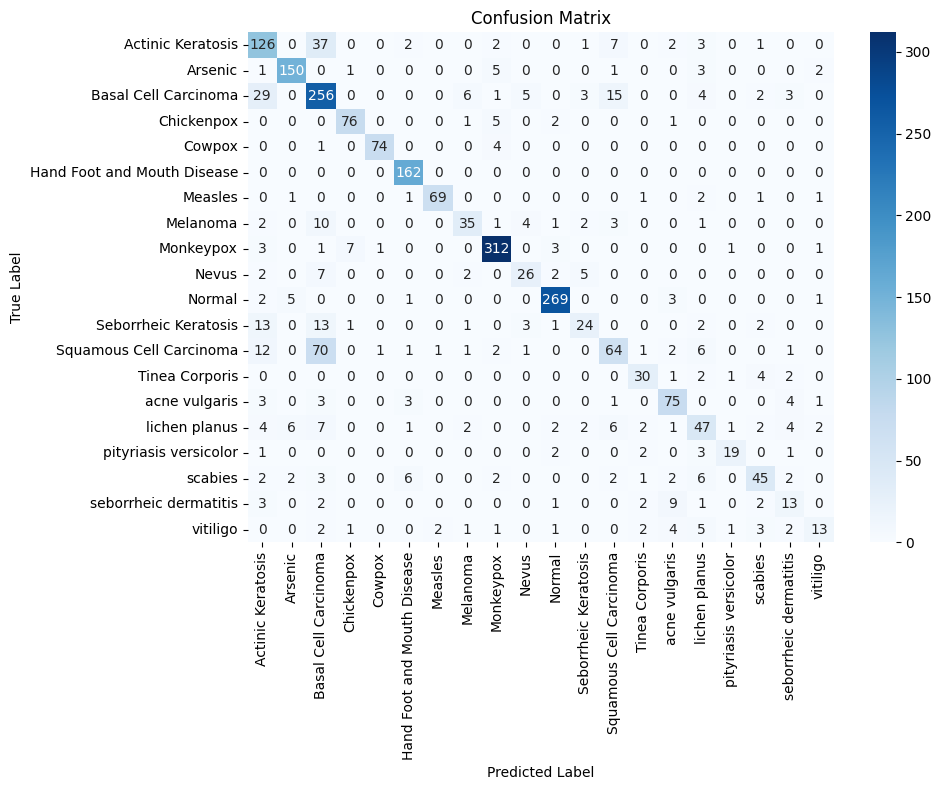

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('EfficientNetB0_confusion_matrix.png', dpi=600)
plt.savefig('EfficientNetB0_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('EfficientNetB0_performance_metrics.csv', index=False)